In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import datetime
import os
import pandas as pd
import scipy.stats as stt

%matplotlib inline

Функции детрендинга и конвертирования географических координат в геомагнитные и наоборот

In [2]:
# детрендинг методом скользящего среднего. degree - окно усреднения
def detrendS(data,degree=10):
    detrended=[0.]*degree # заполняем нулями
    for i in range(degree,len(data)-degree):
        chunk=data[i-degree:i+degree]
        chunk=sum(chunk)/len(chunk)
        detrended.append(data[i]-chunk)
    return detrended+[0.]*degree

In [3]:
# conwert  mag -> geogr & geogr -> mag
# irt = 1: mag -> geogr
# irt = 0: geogr -> mag 
def ggmraw(irt,coor):
    zpi,fa,cod,ci,si=6.28318530718,1.74532925199432e-2, 1.0e-10, 0.980271174621722, 0.197657340379125
    ed=1.0
    
    coorNEW=[0.,0.]
    if(irt == 1):
        dolm=coor[1]
        tetm=coor[0]
        
        xlm=dolm
        bm=tetm
        bg=bm*fa
        #print('1 bg',bg,bm,fa)
        cbm=math.cos(bg)
        sbm=math.sin(bg)
        bg=xlm*fa
        #print('bg',bg)
        clm=math.cos(bg)
        slm=math.sin(bg)
        sbg=sbm*ci-cbm*clm*si
        #print 'sbg   ',sbg,cbm,sbm,clm,slm
        bg=math.asin(sbg)
        cbg=math.cos(bg)
        slg=(cbm*slm)/cbg
        #print 'slg   ',slg,cbg,bg
        clg=(sbm*si+cbm*clm*ci)/cbg
        #print 'clg   ',clg
        xlg=ed-clg
        if((clg > ed) or (xlg < cod)):
            clg=ed
        xlg=ed+clg
        if((clg < -ed) or (xlg < cod)):
            clg=-ed
        ylg=math.acos(clg)
        xlg=ylg
        if(slg < 0.0):
            xlg=zpi-ylg
        bg=bg/fa
        xlg=xlg/fa
        a=(xlg)-69.8
        if(a < 0.0):
            a=a+360.
        tet=bg
        dolg=a
        coorNEW[1]=dolg
        coorNEW[0]=tet 
    else:
        dolg=coor[1]
        tet =coor[0]
        #print(coor)
        bg=(tet)
        xlg=(dolg)
        ylg=xlg+69.8
        bm=bg*fa
        cbg=math.cos(bm)
        sbg=math.sin(bm)
        bm=ylg*fa
        clg=math.cos(bm)
        slg=math.sin(bm)
        sbm=sbg*ci+cbg*clg*si
        bm=math.asin(sbm)
        cbm=math.cos(bm)
        slm=(cbg*slg)/cbm
        clm=(-sbg*si+cbg*clg*ci)/cbm
        xlm=math.acos(clm)
        bg=xlm
        if(slm < 0.0):
            xlm=zpi-bg
        bm=bm/fa
        xlm=xlm/fa
        dolm=(xlm)
        if(abs(tet-180.) < 1.e-3):
            dolm=0.
        tetm=(bm)
        coorNEW[1]=dolm
        coorNEW[0]=tetm
    return (coorNEW)
    

Открываем бинарный файл с 3х-мерным массивом 

In [4]:
NumPy_TEC = np.load('TEC_np.npy')

Feb_TEC = NumPy_TEC[:,:,27:67]
#Feb_TEC = NumPy_TEC[:,:,32:62]
n_lat = len(Feb_TEC[:,0,0])
n_long = len(Feb_TEC[0,:,0])
n_day = len(Feb_TEC[0,0,:])



print(n_lat, n_long, n_day)


(71, 73, 40)


Детрендируем данные по времени

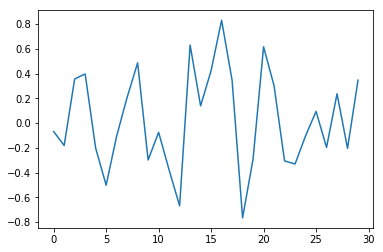

In [5]:
n_dday = len(Feb_TEC[0,0,:]) - 10
Det_TEC_data = np.zeros(n_lat*n_long*n_day).reshape(n_lat, n_long, n_day)
Det_TEC = np.zeros(n_lat*n_long*n_dday).reshape(n_lat, n_long, n_dday)
lat = 0
while lat != n_lat:
    
    for long in range(n_long):
        Det_TEC_data[lat, long, :] = detrendS(Feb_TEC[lat, long, :], 5)
    lat = lat+1
Det_TEC = Det_TEC_data[:,:,5:-5]      
plt.plot(Det_TEC[0,0,:])

In [6]:
geo_lat = np.arange(5., 72.5, 2.5)
geo_long = np.arange(0., 365., 5.)

#geo_lat = np.arange(50., 60, 2.5)
#geo_long = np.arange(0., 25., 5.)

lgt = len(geo_lat)
lggn = len(geo_long)

gcoor = np.zeros(2)
ScPrsn = np.zeros(lgt*lggn).reshape(lgt,lggn)
print(geo_lat, geo_long)
for i in range(lgt):
    for j in range(lggn):
        
        gcoor[0] = geo_lat[i]
        gcoor[1] = geo_long[j]
        # 0 step
        north_lat = round(gcoor[0]/2.5+28)
        north_long = round(gcoor[1]/5)
        #print('NORTH: ',north_lat, norht_long)
        # 1 step
        GMC = ggmraw(0,gcoor)
        GMC[0] = GMC[0]*(-1)
        # 2 step 
        GGC = GGC = ggmraw(1,GMC)
        # 3 step
        south_lat = round(GGC[0]/2.5+28)
        south_long = round(GGC[1]/5)
        #print('SOUTH: ',south_lat, south_long)
        
        ScPrsn[i,j] = stt.pearsonr(Feb_TEC[int(north_lat),int(north_long),:], 
                                   Feb_TEC[int(south_lat),int(south_long),:])[0]
        #ScPrsn[i,j] = stt.pearsonr(Det_TEC[int(north_lat),int(north_long),8:16], 
        #                           Det_TEC[int(south_lat),int(south_long),8:16])[0]
print('Geogr coor:',gcoor,
      'Geomag conjugate coor:', GMC, 
      'Geogr conjugate coor:', GGC, 
      'soth lat point:', south_lat, 
      'north lat point:', north_lat,
     'south long point:', south_long,
     'north long point:', north_long)

(array([ 5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. , 27.5, 30. ,
       32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. , 52.5, 55. , 57.5,
       60. , 62.5, 65. , 67.5, 70. ]), array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
       220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270.,
       275., 280., 285., 290., 295., 300., 305., 310., 315., 320., 325.,
       330., 335., 340., 345., 350., 355., 360.]))
('Geogr coor:', array([ 70., 360.]), 'Geomag conjugate coor:', [-70.8209771044691, 102.2970065608405], 'Geogr conjugate coor:', [-65.78785172078241, 58.69482379500626], 'soth lat point:', 2.0, 'north lat point:', 56.0, 'south long point:', 12.0, 'north long point:', 72.0)


In [7]:
gcoor=[70.,45.]
GMC = ggmraw(0,gcoor)
GGC = ggmraw(1,GMC)
print(GMC, GGC)

([63.22690676028338, 136.42926865566827], [69.99999999999999, 44.99999999999996])


In [8]:
Point_lat = GGC[0]/2.5+28
Point_long = GGC[1]/5
print(Point_lat, round(Point_lat), Point_long, round(Point_long))

(55.99999999999999, 56.0, 8.999999999999991, 9.0)


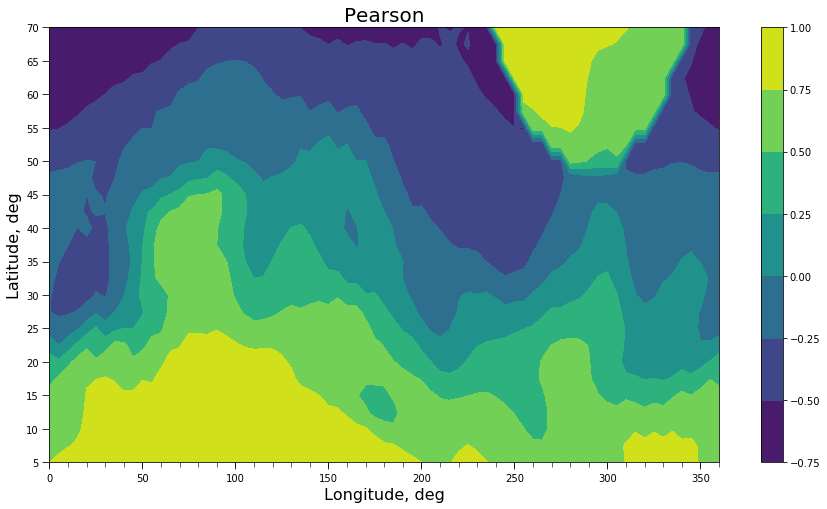

In [9]:
fig, ax1 = plt.subplots( figsize = (15,8))

a = ax1.contourf(geo_long, geo_lat, ScPrsn)
ax1.set_title('Pearson', size = 20)
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(MultipleLocator(10))
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=5)
ax1.set_ylabel('Latitude, deg', size=16)
ax1.set_xlabel('Longitude, deg', size=16)
fig.colorbar(a, ax=ax1)
plt.savefig('MagneticalConjurgatePoints.png')

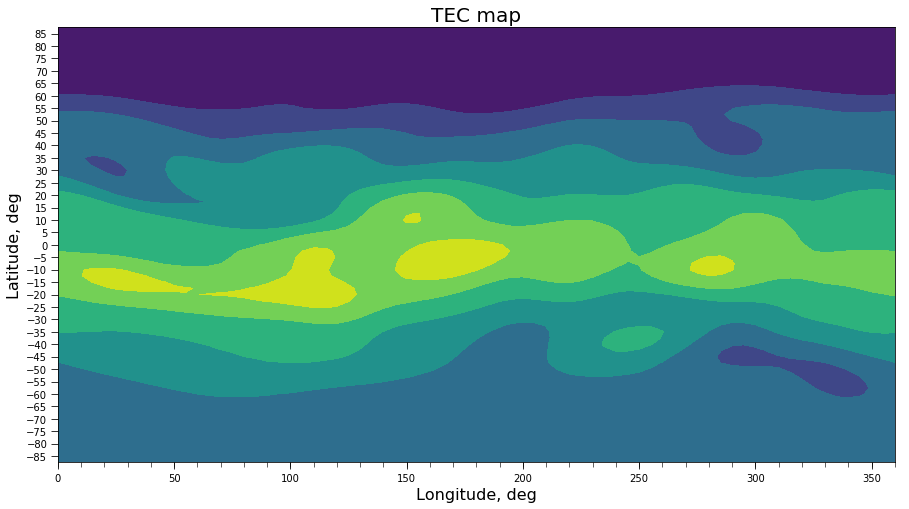

In [10]:
fig, ax1 = plt.subplots( figsize = (15,8))
Y = np.arange(87.5, -90, -2.5)

ax1.set_title('TEC map', size = 20)
plt.contourf(geo_long, Y, Feb_TEC[:,:, 5])
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(MultipleLocator(10))
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=5)
ax1.set_ylabel('Latitude, deg', size=16)
ax1.set_xlabel('Longitude, deg', size=16)
#fig.colorbar(a, ax=ax1)
plt.savefig('TEC_MAP.png', dpi =900)